In [1]:
import keras
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

C:\Users\Siddh\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# This is the same as Model Building. But in this we bin the number of products used to 5 buckets.

In [2]:
count = pd.read_csv('excel_files/prepared.csv')
count['user'] = count.user.astype('category').cat.codes.values
count['item'] = count.item.astype('category').cat.codes.values

In [3]:
df = pd.read_csv('excel_files/diff.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df.rename({'fullname_X':'user','product_id':'item'},axis =1, inplace=True)
df['nuser'] = df.user.astype('category').cat.codes.values
df['nitem'] = df.item.astype('category').cat.codes.values

In [168]:
df.head()

,user,item,product_name,created_day,diff,nuser,nitem
0,255495,7,Send Money,2018-08-06,91,29565,2
1,359354,200,NT Prepaid Topup,2018-08-06,91,44546,29
2,429302,200,NT Prepaid Topup,2018-08-06,91,57521,29
3,402598,15,Ncell Topup,2018-08-06,91,52299,5
4,483671,200,NT Prepaid Topup,2018-08-06,91,69014,29


In [169]:
count.head()

,user,item,counts
0,0,2,12
1,0,3,3
2,0,5,8
3,0,13,1
4,0,29,1


In [170]:
item_dict = dict(zip(df.nitem,df.product_name))
user_dict=dict(zip(df.nuser,df.user))

# Binning

In [171]:
def binning(X):
    col = X[0]
    if col==1:
        return 1
    elif col==2 :
        return 2
    elif col>2.0 and col<6.0:
        return 3
    elif col>=6.0 :
        return 4

In [172]:
count['counts']=count[['counts']].apply(binning,axis = 1)

In [173]:
count['counts'] = count.counts.astype('category')

In [72]:
dummy = pd.get_dummies(count['counts'],drop_first=True,prefix='count')

In [73]:
count = pd.concat([count, dummy], axis=1)

In [77]:
count.drop(columns=['counts'],inplace=True)

In [218]:
count.head()

,user,item,counts
0,0,2,4
1,0,3,3
2,0,5,4
3,0,13,1
4,0,29,1


In [217]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(count, test_size=0.2)

In [121]:
y_train_one_hot = train.iloc[:,2:5]

# MAT FACT

In [160]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam,SGD,Nadam
from keras.utils.vis_utils import model_to_dot
n_users, n_item = len(count.user.unique()), len(count.item.unique())
n_latent_factors = 5

In [163]:
from keras.constraints import non_neg
item_input = keras.layers.Input(shape=[1],name='Item')
item_embedding = keras.layers.Embedding(n_item + 1, n_latent_factors, name='item-Embedding')(item_input)
item_vec = keras.layers.Flatten(name='FlattenItems')(item_embedding)
user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding',embeddings_constraint=non_neg())(user_input))
prod = keras.layers.dot([item_vec, user_vec],axes=1)
model = keras.Model([user_input, item_input], prod)
model.compile('adam', 'mean_squared_error',metrics=['accuracy'])

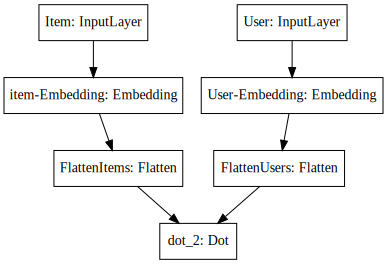

In [164]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(model, to_file='Mat Fact.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [178]:
history = model.fit([train.user, train.item], train.counts, epochs=10, verbose=1)

Epoch 1/10
417454/417454 [==============================] - 81s 195us/step - loss: 3.8347 - acc: 0.1813
Epoch 2/10
417454/417454 [==============================] - 80s 191us/step - loss: 1.4571 - acc: 0.3411
Epoch 3/10
417454/417454 [==============================] - 85s 203us/step - loss: 1.2661 - acc: 0.3541
Epoch 4/10
417454/417454 [==============================] - 85s 203us/step - loss: 1.1781 - acc: 0.3790
Epoch 5/10
417454/417454 [==============================] - 81s 195us/step - loss: 1.1345 - acc: 0.3815
Epoch 6/10
417454/417454 [==============================] - 80s 192us/step - loss: 1.0954 - acc: 0.4014
Epoch 7/10
417454/417454 [==============================] - 81s 193us/step - loss: 1.0727 - acc: 0.39660s - loss: 1.0727 - acc: 0.396
Epoch 8/10
417454/417454 [==============================] - 81s 195us/step - loss: 1.0471 - acc: 0.4148
Epoch 9/10
417454/417454 [==============================] - 81s 194us/step - loss: 1.0291 - acc: 0.4137
Epoch 10/10
417454/417454 [=======

# neural

In [225]:
n_latent_factors_user = 5
n_latent_factors_item = 8

item_input = keras.layers.Input(shape=[1],name='Item')
item_embedding = keras.layers.Embedding(n_item + 1, n_latent_factors_item, name='item-Embedding')(item_input)
item_vec = keras.layers.Flatten(name='FlattenMovies')(item_embedding)
item_vec = keras.layers.Dropout(0.2)(item_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.concatenate([item_vec, user_vec],name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected',activation='softmax')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1',activation='softmax')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2',activation='softmax')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='softmax')(dense_3)


result = keras.layers.Dense(1, activation='softmax',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, item_input], result)
model.compile(optimizer=adam,loss= 'mean_squared_error',metrics=['accuracy',metrics.mean_absolute_error])

In [226]:
history = model.fit([train.user, train.item], train.counts, epochs=10, verbose=1,validation_data=([test.user,test.item],test.counts))

Train on 417454 samples, validate on 104364 samples
Epoch 1/10
417454/417454 [==============================] - 96s 231us/step - loss: 3.4416 - acc: 0.3669 - mean_absolute_error: 1.3874 - val_loss: 3.4217 - val_acc: 0.3695 - val_mean_absolute_error: 1.3801
Epoch 2/10
417454/417454 [==============================] - 94s 226us/step - loss: 3.4416 - acc: 0.3669 - mean_absolute_error: 1.3874 - val_loss: 3.4217 - val_acc: 0.3695 - val_mean_absolute_error: 1.3801
Epoch 3/10
417454/417454 [==============================] - 92s 220us/step - loss: 3.4416 - acc: 0.3669 - mean_absolute_error: 1.3874 - val_loss: 3.4217 - val_acc: 0.3695 - val_mean_absolute_error: 1.3801
Epoch 4/10
417454/417454 [==============================] - 90s 215us/step - loss: 3.4416 - acc: 0.3669 - mean_absolute_error: 1.3874 - val_loss: 3.4217 - val_acc: 0.3695 - val_mean_absolute_error: 1.3801
Epoch 5/10
417454/417454 [==============================] - 94s 225us/step - loss: 3.4416 - acc: 0.3669 - mean_absolute_error: 1

# MOVIE LENS

In [189]:
movie = pd.read_csv('ratings.dat',sep = '::',names=['user','item','counts','time'])

In [190]:
movie.head()

,user,item,counts,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [192]:
movie = movie[['user','item','counts']]

In [193]:
movie.head()

,user,item,counts
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [ ]:
movie['user'] = movie.user.astype('category').cat.codes.values
movie['item'] = movie.item.astype('category').cat.codes.values

In [213]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(movie, test_size=0.2)

In [201]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam,SGD,Nadam
from keras.utils.vis_utils import model_to_dot
n_users, n_item = len(movie.user.unique()), len(movie.item.unique())
n_latent_factors = 5

In [206]:
from keras.constraints import non_neg
item_input = keras.layers.Input(shape=[1],name='Item')
item_embedding = keras.layers.Embedding(n_item + 1, n_latent_factors, name='item-Embedding')(item_input)
item_vec = keras.layers.Flatten(name='FlattenItems')(item_embedding)
user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding',embeddings_constraint=non_neg())(user_input))
prod = keras.layers.dot([item_vec, user_vec],axes=1)
model = keras.Model([user_input, item_input], prod)
model.compile(Adam(.009), 'mean_squared_error',metrics=['accuracy'])

In [207]:
history = model.fit([train.user, train.item], train.counts, epochs=10, verbose=1,validation_split=.1)

Train on 720150 samples, validate on 80017 samples
Epoch 1/10
720150/720150 [==============================] - 109s 151us/step - loss: 1.6414 - acc: 0.3367 - val_loss: 1.2028 - val_acc: 0.3566
Epoch 2/10
720150/720150 [==============================] - 126s 175us/step - loss: 1.1431 - acc: 0.3666 - val_loss: 1.1259 - val_acc: 0.3717
Epoch 3/10
720150/720150 [==============================] - 119s 165us/step - loss: 1.0936 - acc: 0.3753 - val_loss: 1.1049 - val_acc: 0.3740
Epoch 4/10
720150/720150 [==============================] - 117s 162us/step - loss: 1.0761 - acc: 0.3785 - val_loss: 1.0902 - val_acc: 0.3776
Epoch 5/10
720150/720150 [==============================] - 108s 150us/step - loss: 1.0644 - acc: 0.3806 - val_loss: 1.0791 - val_acc: 0.3779
Epoch 6/10
720150/720150 [==============================] - 103s 143us/step - loss: 1.0507 - acc: 0.3826 - val_loss: 1.0739 - val_acc: 0.3767
Epoch 7/10
720150/720150 [==============================] - 107s 149us/step - loss: 1.0389 - acc:

In [228]:
model.save('models/neural_bin.h5')

In [215]:
n_latent_factors=5
from keras.constraints import non_neg
from keras import metrics
item_input = keras.layers.Input(shape=[1],name='Item')
item_embedding = keras.layers.Embedding(n_item + 1, n_latent_factors, name='item-Embedding')(item_input)
item_vec = keras.layers.Flatten(name='FlattenItems')(item_embedding)
user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding',embeddings_constraint=non_neg())(user_input))
prod = keras.layers.dot([item_vec, user_vec],axes=1)
model = keras.Model([user_input, item_input], prod)
model.compile(Adam(.009), 'mean_squared_error',metrics=['accuracy',metrics.mean_absolute_error])
history = model.fit([train.user, train.item], train.counts, epochs=10, verbose=1,validation_data=([test.user,test.item],test.counts))

Train on 800167 samples, validate on 200042 samples
Epoch 1/10
800167/800167 [==============================] - 120s 150us/step - loss: 1.5975 - acc: 0.3385 - mean_absolute_error: 0.9656 - val_loss: 1.1733 - val_acc: 0.3615 - val_mean_absolute_error: 0.8571
Epoch 2/10
800167/800167 [==============================] - 114s 143us/step - loss: 1.1366 - acc: 0.3675 - mean_absolute_error: 0.8441 - val_loss: 1.1152 - val_acc: 0.3683 - val_mean_absolute_error: 0.8376
Epoch 3/10
800167/800167 [==============================] - 117s 147us/step - loss: 1.0869 - acc: 0.3766 - mean_absolute_error: 0.8243 - val_loss: 1.0978 - val_acc: 0.3761 - val_mean_absolute_error: 0.8280
Epoch 4/10
800167/800167 [==============================] - 121s 151us/step - loss: 1.0663 - acc: 0.3797 - mean_absolute_error: 0.8162 - val_loss: 1.0784 - val_acc: 0.3792 - val_mean_absolute_error: 0.8197
Epoch 5/10
800167/800167 [==============================] - 119s 149us/step - loss: 1.0517 - acc: 0.3831 - mean_absolute_err

# Normalize

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
scaler = MinMaxScaler((1,10))

In [32]:
scaled_count = scaler.fit_transform(count[['counts']].values)

In [33]:
scaled_count.shape

(521818, 1)

In [34]:
count['scaled'] = pd.DataFrame(scaled_count)

In [35]:
count

,user,item,counts,scaled
0,0,2,12,1.668919
1,0,3,3,1.121622
2,0,5,8,1.425676
3,0,13,1,1.000000
4,0,29,1,1.000000
5,0,31,3,1.121622
6,0,48,4,1.182432
7,0,55,6,1.304054
8,0,121,5,1.243243
9,0,141,2,1.060811


In [36]:
item_dict = dict(zip(df.nitem,df.product_name))
user_dict=dict(zip(df.nuser,df.user))

In [37]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam,SGD,Nadam
from keras.utils.vis_utils import model_to_dot
n_users, n_item = len(count.user.unique()), len(count.item.unique())

In [38]:
from keras import metrics

In [39]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(count, test_size=0.2)

In [40]:
n_latent_factors_user = 5
n_latent_factors_item = 8

item_input = keras.layers.Input(shape=[1],name='Item')
item_embedding = keras.layers.Embedding(n_item + 1, n_latent_factors_item, name='item-Embedding')(item_input)
item_vec = keras.layers.Flatten(name='FlattenMovies')(item_embedding)
item_vec = keras.layers.Dropout(0.2)(item_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.concatenate([item_vec, user_vec],name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected',activation='softmax')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1',activation='softmax')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2',activation='softmax')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='softmax')(dense_3)


result = keras.layers.Dense(1, activation='softmax',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, item_input], result)
model.compile(optimizer=adam,loss= 'mean_squared_error',metrics=['accuracy',metrics.mean_absolute_error])

In [42]:
history = model.fit([train.user, train.item], train.scaled, epochs=2, verbose=1,validation_data=([test.user,test.item],test.scaled))

Train on 417454 samples, validate on 104364 samples
Epoch 1/2
417454/417454 [==============================] - 103s 248us/step - loss: 0.5714 - acc: 0.3673 - mean_absolute_error: 0.3273 - val_loss: 0.5805 - val_acc: 0.3678 - val_mean_absolute_error: 0.3292
Epoch 2/2
417454/417454 [==============================] - 95s 228us/step - loss: 0.5714 - acc: 0.3673 - mean_absolute_error: 0.3273 - val_loss: 0.5805 - val_acc: 0.3678 - val_mean_absolute_error: 0.3292


In [88]:
model.save('models/neural_normalized.h5')

In [45]:
count

,user,item,counts,scaled
0,0,2,12,1.668919
1,0,3,3,1.121622
2,0,5,8,1.425676
3,0,13,1,1.000000
4,0,29,1,1.000000
5,0,31,3,1.121622
6,0,48,4,1.182432
7,0,55,6,1.304054
8,0,121,5,1.243243
9,0,141,2,1.060811


In [54]:
df = pd.read_csv('excel_files/diff.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df.rename({'fullname_X':'user','product_id':'item'},axis =1, inplace=True)
df['nuser'] = df.user.astype('category').cat.codes.values
df['nitem'] = df.item.astype('category').cat.codes.values

In [55]:
item = []
rate = []
user = []
for i in range(0,50): #user
    for j in range(df.nitem.nunique()): #item
        #if the item has not been used for __ days   
        temp = df.loc[(df.nuser == i) & (df.nitem == j)]
        if temp['diff'].min()<1200:
            #print('the user {} used the prduct {} {} days ago and rated {}, count{}'.format(i,j,temp['diff'].min(),non_binned.predict([[i],[j]])[0][0],temp.shape))
            continue
        else:
            item.append(j)
            user.append(i)
            rate.append((model.predict([[i],[j]])[0][0]))
    print('done for user ',i)

done for user  0
done for user  1
done for user  2
done for user  3
done for user  4
done for user  5
done for user  6
done for user  7
done for user  8
done for user  9
done for user  10
done for user  11
done for user  12
done for user  13
done for user  14
done for user  15
done for user  16
done for user  17
done for user  18
done for user  19
done for user  20
done for user  21
done for user  22
done for user  23
done for user  24
done for user  25
done for user  26
done for user  27
done for user  28
done for user  29
done for user  30
done for user  31
done for user  32
done for user  33
done for user  34
done for user  35
done for user  36
done for user  37
done for user  38
done for user  39
done for user  40
done for user  41
done for user  42
done for user  43
done for user  44
done for user  45
done for user  46
done for user  47
done for user  48
done for user  49


In [56]:
rating = pd.DataFrame(data={'user':user,'item':item,'rate':rate})

test = pd.DataFrame(columns=['user','p1','p2','p3','p4','p5','p6','p7','p8','p9','p10'])
for i in range(0,50):
    asdf = rating.loc[rating.user==i].sort_values('rate',ascending = False).head(10).item
    lis = []
    try:
        lis.append(i)
        for j in asdf:
            lis.append(j)
        test.loc[len(test)] = lis
    except:
        print('err')
        
#test['user'] = test['user'].replace(user_dict)
test['p1']=test['p1'].map(item_dict)
test['p2']=test['p2'].map(item_dict)
test['p3']=test['p3'].map(item_dict)
test['p4']=test['p4'].map(item_dict)
test['p5']=test['p5'].map(item_dict)
test['p6']=test['p6'].map(item_dict)
test['p7']=test['p7'].map(item_dict)
test['p8']=test['p8'].map(item_dict)
test['p9']=test['p9'].map(item_dict)
test['p10']=test['p10'].map(item_dict)

test['user'] = test['user'].map(user_dict)

In [87]:
test.to_excel('excel_files/neural_normalised.xlsx')